In [2]:
import os
os.environ["PATH"] += ":/usr/local/texlive/2024/bin/universal-darwin"

import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from helpers import save_dict,load_dict
from plotting_helpers import add_energy_legends, add_gridlines, set_x_ticks


import sys
sys.path.append('../')
from interactions import buildlattice_alltoall, generate_sublattices_square
from correlations import calculate_structure_factor
from interactions import get_longest_r_interactions_square

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 15,
    "font.family": "Helvetica"
})

column_width = 3.75
square_fig_size=(2*column_width,3/2*column_width)


# Helper Functions

In [4]:
def calculate_longrC(longr_interactions, Sij, zz=False):
    to_sum = []
    for interaction in longr_interactions:
        Sij_int = Sij[interaction[0],interaction[1]]
        if zz:
            Sij_int *= 3
        to_sum.append(Sij_int)
    to_sum_np = np.array(to_sum)
    return np.mean(to_sum_np)/4, np.std(to_sum_np)/np.sqrt(len(to_sum_np))

In [5]:
def get_minus_sign_matrix(L):
    N = L**2
    _, _, A_sites, B_sites = generate_sublattices_square(L,L)
    interactions = np.array(buildlattice_alltoall(L))
    minus_signs_matrix = np.ones((N,N))
    for interaction in interactions:
        s1, s2 = interaction
        no_minus = ((s1 in A_sites) ^ (s2 in B_sites)) or ((s1 in B_sites) ^ (s2 in A_sites))
        minus_signs_matrix[s1,s2] = 2 * no_minus - 1
    return minus_signs_matrix

# Load Data

In [6]:
Ls_1 = np.arange(6,21,2)
Ls_2 = np.arange(24,33,4)
Ls = np.concatenate((Ls_1,Ls_2),axis=0)

rates = [0.475, 0.25]
scales = [0.25,0.5,1.,2.,4.]

In [7]:
energy_plotting_data = load_dict('./final_data/final_energy_data_plotting.pkl')
corr_plotting_data = load_dict('./final_data/final_correlations_data_plotting.pkl')
reference_data = load_dict('./final_data/references.pkl')

# Plot

In [8]:
colorscale = plt.get_cmap('plasma')
shades = np.linspace(0.,0.9,len(scales)+1)[::-1][:-1]
colors = colorscale(shades)
markers = {0.475:'s',0.25:'8'}
markersizes = {0.475:6,0.25:8}
alphas = {0.475:0.5,0.25:1.0}
linestyles= {0.475:'--',0.25:'-'}
bigger_font_size = 22

colorscale_C = plt.get_cmap('viridis')
colors_C = colorscale_C(shades)


### Energy relative error VS Sk relative error

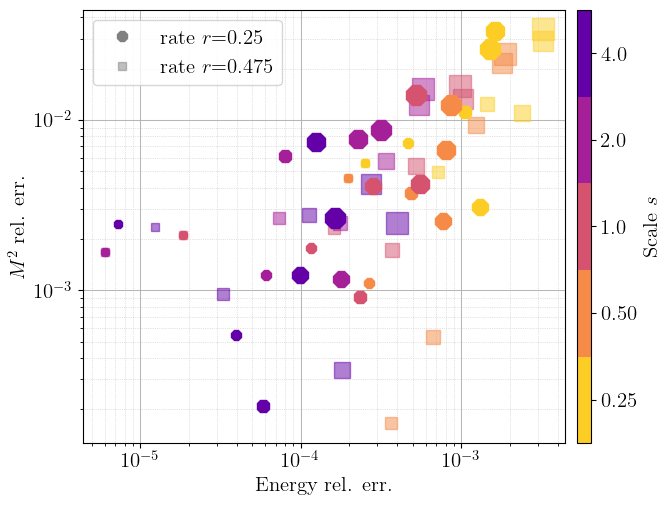

In [10]:
plot_Ls = Ls[:6]

p1 = (1.,0)
p2 = (0,1.)

plt.figure(figsize=square_fig_size)

bc = "periodic"
reference_vals = reference_data[bc]
energy_data = energy_plotting_data[bc]
corr_data = corr_plotting_data[bc]

show_C = False

for rate_i, rate in enumerate(rates):
    for scale_i, scale in enumerate(scales):
        for L_i, L in enumerate(plot_Ls):    
            N = L**2
            relative_E_error = np.nan
            relative_Sk_error = np.nan
            relative_C_error = np.nan

            if 'energies' in energy_data[f"rate={rate}"][f"scale={scale}"].keys():
                en = np.real(energy_data[f"rate={rate}"][f"scale={scale}"]['energies'][L_i])
                relative_E_error = abs(en - reference_vals['energy'][L_i])/abs(reference_vals['energy'][L_i])

            if 'Sk from SiSj' in corr_data[f"rate={rate}"][f"scale={scale}"].keys():
                Sk = corr_data[f"rate={rate}"][f"scale={scale}"]['Sk from SiSj']
                if len(Sk) > 0:
                    relative_Sk_error = abs(Sk[L_i] - reference_vals['M^2 from Sk'][L_i])/abs(reference_vals['M^2 from Sk'][L_i])
                    plt.errorbar(relative_E_error,relative_Sk_error,
                                marker=markers[rate],ms=L,fmt='o',capsize=5,
                                mfc=colors[scale_i],mec=colors[scale_i],c=colors[scale_i], alpha=alphas[rate],
                                label=f'{L},{scale},{rate}')          
                      
            if show_C:
                if 'C(L/2,L/2)' in corr_data[f"rate={rate}"][f"scale={scale}"].keys():
                    C = corr_data[f"rate={rate}"][f"scale={scale}"]['C(L/2,L/2)']
                    if len(C) > 0:
                        relative_C_error = abs(C[L_i] - reference_vals['M^2 from C'][L_i])/abs(reference_vals['M^2 from C'][L_i])
                        plt.errorbar(relative_E_error,relative_C_error,
                                    marker=markers[rate],ms=L,fmt='o',capsize=5,
                                    mfc=colors_C[scale_i],mec=colors_C[scale_i],c=colors_C[scale_i], alpha=alphas[rate],
                                    label=f'{L},{scale}')  

x = np.arange(-5,-1,0.5)
y = np.linspace(-5,-1,len(x))

add_energy_legends(show_runs=True,show_C=show_C)
add_gridlines()

plt.grid(visible=True, which='major', linestyle='-', linewidth=0.75, alpha=0.9)  # Major gridlines
plt.minorticks_on()
plt.grid(visible=True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7)  # Minor gridlines

# plt.legend()
if show_C:
    plt.ylabel(r'$M^2$, $M^2_C$ rel. err.')
else:
    plt.ylabel(r'$M^2$ rel. err.')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy rel. err.')

filename='relative_errors'
if show_C:
    filename+='_with_C.pdf'
else:
    filename+='.pdf'
plt.savefig('./final_figures/'+filename)
plt.show()

I don't have exact values for larger system sizes, but I could use our extrapolation from zero-var energies as a baseline